# What are the characteristics of detectable chargeable materials in AEM data?

**Author**: [Seogi Kang](https://github.com/sgkang)

This notebooks investigate a question: "What are the characteristics of detectable chargeable materials in AEM data?". 
This notebook was used to produce Figures 13, 14 in Kang et al. (2019). 

In [2]:
from SimPEG import *
from SimPEG import EM
from scipy.constants import mu_0
import numpy as np
from simpegEMIP.StretchedExponential import SEInvImpulseProblem, SESurvey
from simpegEMIP.TDEM import Problem3D_e, Problem3DEM_e, Rx, Survey
from simpegEMIP.TDEM.Utils import get_dobs_pn
import matplotlib.pyplot as plt
from pymatsolver import PardisoSolver
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
%matplotlib inline

In [3]:
import matplotlib 
matplotlib.rcParams["font.size"] = 16

In [4]:
figdir = "./figures/"

## Step 1: Compute rectangular waveforms, then tranform them in to frequency-domain

- Grounded DC-IP: 0.125Hz base frequency (8s period)
- Airborne EM: 25Hz base frequency (0.04s period)

In [5]:
from scipy.signal import square
from scipy.fftpack import fft, fftshift
def rect_time_to_frequency(dt, f_base, n_period=2):
    T_base = 1./f_base
    n = int(np.floor(T_base/dt)*n_period)
    t = np.linspace(0., n*dt, n)
    out_t = square(2 * np.pi * f_base * t, duty=0.5)
    out_f = fft(out_t) * 2.0/n
    f = np.linspace(0., 1./(2.*dt), n//2)
    out = {"t":t, "f":f[0:n//2], "out_t": out_t, "out_f":out_f[0:n//2]}
    return out

Text(0.5, 0, 'Time (s)')

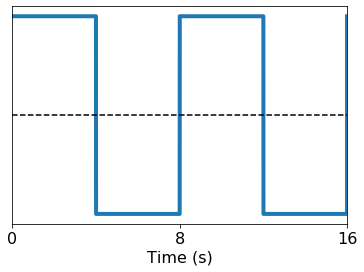

In [6]:
out_grounded = rect_time_to_frequency(1e-4, 0.125, 2)
out_aem = rect_time_to_frequency(1e-6, 25., 4)

plt.plot(out_grounded['t'], out_grounded['out_t'], lw=4)
plt.plot(np.r_[0, 16], np.r_[0., 0.], 'k--')
plt.xlim(0, 16)
plt.xticks([0., 8., 16.])
plt.yticks([])
plt.xlabel("Time (s)")

Text(0.5, 0, 'Time (s)')

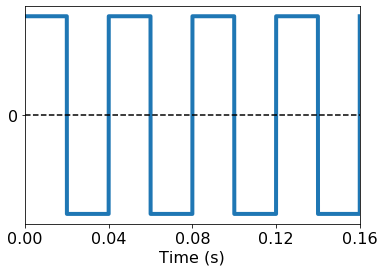

In [7]:
plt.plot(out_aem['t'], out_aem['out_t'], lw=4)
plt.xlim(0, out_aem['t'].max())
plt.plot(np.r_[0, out_aem['t'].max()], np.r_[0., 0.], 'k--')
plt.xticks([0,1./25, 2./25, 3./25, 4./25])
plt.yticks([0.])
plt.xlabel("Time (s)")

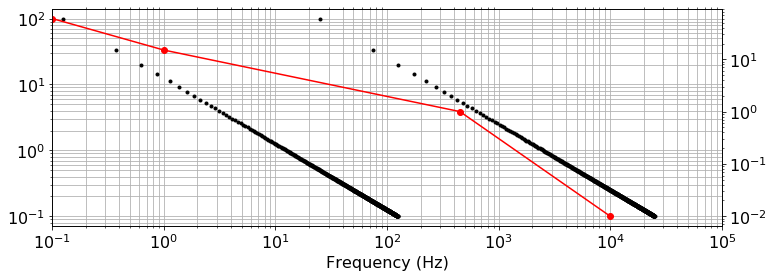

In [8]:
from scipy.interpolate import interp1d
grain_size = np.array([0.01, 1, 15, 60])
frequency_grain_size = np.array([1e4, 450., 1., 0.1])
grain_size_fun = interp1d(frequency_grain_size, grain_size)
plt.figure(figsize = (12, 4))
temp_grounded = abs(out_grounded['out_f'])/abs(out_grounded['out_f']).max()
inds = temp_grounded>1e-3
ax = plt.subplot(111)
ax.loglog(out_grounded['f'][inds], temp_grounded[inds]*100., 'k.')
temp_aem = abs(out_aem['out_f'])/abs(out_aem['out_f']).max()
inds = temp_aem>1e-3
ax.loglog(out_aem['f'][inds], temp_aem[inds]*100., 'k.')
fmin_grounded, fmax_grounded = out_grounded['f'][inds].min(), out_grounded['f'][inds].max()
fmin_aem, fmax_aem = out_aem['f'][inds].min(), out_aem['f'][inds].max()
ax.set_xlim(1e-1, 1e5)
ax.tick_params(axis='x',which='minor', bottom='on', top='on')
ax.grid(which='both')
ax.set_xlabel("Frequency (Hz)")
ax_1 = ax.twinx()
ax_1.loglog(frequency_grain_size, grain_size, 'ro-')

## Step2: Make a diagram illustrating various IP effects and surveys as a function of frequency

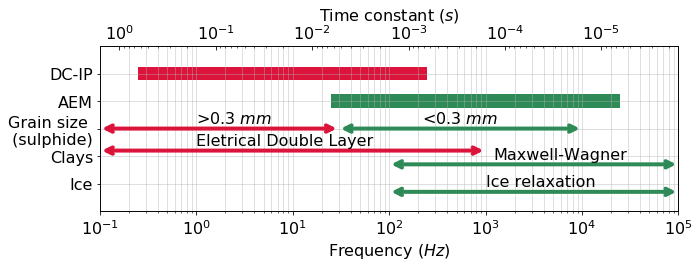

In [9]:
def tau_from_peak_freq(f):
    return 1./(2*np.pi*f)

freqs = 10.**(-1 + np.arange(7))
taus = tau_from_peak_freq(freqs)

fig = plt.figure(figsize = (10, 4))
ax = plt.subplot(111)
ax.set_xlim(1e-1, 1e5)
ax.set_xscale('log')
ax.grid(which='both', alpha=0.5)
ax.set_xlabel("Frequency ($Hz$)")
ax.barh(4, fmax_grounded-fmin_grounded, 0.5, fmin_grounded, color='crimson')
ax.barh(3, fmax_aem-fmin_aem, 0.5, fmin_aem, color='seagreen')
ax.annotate(
    s='', xy=(30.,2), xytext=(0.1,2), arrowprops=dict(arrowstyle='<->',fc="crimson", ec="crimson", lw=4)
)
ax.annotate(
    s='', xy=(1e4,2), xytext=(30.,2), arrowprops=dict(arrowstyle='<->',fc="seagreen", ec="seagreen", lw=4)
)
ax.annotate(
    s='', xy=(1e3,1.2), xytext=(0.1,1.2), arrowprops=dict(arrowstyle='<->',fc="crimson", ec="crimson", lw=4)
)
ax.annotate(
    s='', xy=(1e5,0.7), xytext=(1e2,0.7), arrowprops=dict(arrowstyle='<->',fc="seagreen", ec="seagreen", lw=4)
)

ax.annotate(
    s='', xy=(1e5,-0.3), xytext=(1e2,-0.3), arrowprops=dict(arrowstyle='<->',fc="seagreen", ec="seagreen", lw=4)
)
tau_min, tau_max = taus.min(), taus.max()
axT = ax.twiny()
axT.set_xlim(tau_max, tau_min)

axT.tick_params(which='both', direction = 'in')
axT.set_xscale('log')
axT.set_xlabel('Time constant ($s$)')
ax.text(1, 2.2, ">0.3 $mm$")
ax.text(220, 2.2, "<0.3 $mm$")
ax.text(1, 1.4, "Eletrical Double Layer")
ax.text(1.2*1e3, 1.2-0.3, "Maxwell-Wagner")
ax.text(1*1e3, 1.2-0.3-1, "Ice relaxation")

ax.set_ylim(-1, 5)
ax.set_yticks([0, 1, 2, 3, 4])
ax.set_yticklabels(["Ice", "Clays", "Grain size \n (sulphide)", "AEM", "DC-IP"])
plt.tight_layout()
fig.savefig(figdir + "polarization_spectrum")

## Step 3: Compute type curves

- Type A: Clay or sulphides 
- Type B: Clay or sulphides (finer-grained)
- Type C: Type A, but having a deep conductor
- Type D: Ice

In [10]:
# Locations of the receiver and source loops
rxloc = np.array([[0., 0., 30.]])
srcloc = np.array([[0., 0., 30.]])


moment = np.pi*(13.)**2 / 1e12
area = np.pi*(13**2)
noise_floor = 1e-4

# Generate 2D cylindrically symmetric mesh
cs, ncx, ncz, npad = 10., 25, 20, 20
hx = [(cs,ncx), (cs,npad,1.3)]
hz = [(cs,npad,-1.3), (cs,ncz), (cs,npad,1.3)]
mesh = Mesh.CylMesh([hx,1,hz], '00C')    

### Step3-1 Type A: Clay or sulphides 

In [11]:
airind = mesh.gridCC[:,2]>0.
blkind  = np.logical_and(mesh.gridCC[:,0]<200., (mesh.gridCC[:,2]<0)&(mesh.gridCC[:,2]>-150)&(mesh.gridCC[:,2]<-50))        
sig_2 = 1./50
sig_1 = 0.001
eta_se, tau_se, c_se = 0.1, 0.001, 0.7
    
sigmaInf = np.ones(mesh.nC) * sig_1
sigmaInf[airind] = 1e-8
sigmaInf[blkind] = sig_2
eta = np.zeros(mesh.nC)
eta[blkind] = eta_se
tau = np.ones(mesh.nC) * tau_se
c = np.ones(mesh.nC) * c_se 

rx_emip = Rx.Point_dbdt(rxloc, np.logspace(np.log10(1e-5), np.log10(0.009), 51), 'z')
src_emip = EM.TDEM.Src.CircularLoop([rx_emip], waveform=EM.TDEM.Src.StepOffWaveform(), loc=srcloc, radius = 13.)
survey_emip = Survey([src_emip])
prb_emip = Problem3D_e(mesh, sigmaInf=sigmaInf, eta=eta, tau=tau, c=c)
prb_emip.timeSteps = [(1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 10), (2e-05, 10), (4e-05, 10), (8e-05, 10), (1.6e-04, 10), (3.2e-04, 20)]
prb_emip.Solver = PardisoSolver
prb_emip.pair(survey_emip)
m = np.r_[sigmaInf, eta, tau, c]
data_typeA = survey_emip.dpred(m)

/Users/sgkang/Projects/simpeg/SimPEG/Props.py:400: UserWarning: Cannot add model as there are no active mappings, choose from: ['cMap', 'etaMap', 'rhoMap', 'sigmaInfMap', 'sigmaMap', 'tauMap']
  "', '".join(self._all_map_names)


### Step3-2 Type B: Clay or sulphides  (finer-grained)

In [12]:
airind = mesh.gridCC[:,2]>0.
blkind  = np.logical_and(mesh.gridCC[:,0]<200., (mesh.gridCC[:,2]<0)&(mesh.gridCC[:,2]>-150)&(mesh.gridCC[:,2]<-50))    
sig_2 = 1./50
sig_1 = 0.001
eta_se, tau_se, c_se = 0.1, 0.0001, 0.7

sigmaInf = np.ones(mesh.nC) * sig_1
sigmaInf[airind] = 1e-8
sigmaInf[blkind] = sig_2
eta = np.zeros(mesh.nC)
eta[blkind] = eta_se
tau = np.ones(mesh.nC) * tau_se
c = np.ones(mesh.nC) * c_se 

rx_emip = Rx.Point_dbdt(rxloc, np.logspace(np.log10(1e-5), np.log10(0.009), 51), 'z')
src_emip = EM.TDEM.Src.CircularLoop([rx_emip], waveform=EM.TDEM.Src.StepOffWaveform(), loc=srcloc, radius = 13.)
survey_emip = Survey([src_emip])
prb_emip = Problem3D_e(mesh, sigmaInf=sigmaInf, eta=eta, tau=tau, c=c)
prb_emip.timeSteps = [(1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 10), (2e-05, 10), (4e-05, 10), (8e-05, 10), (1.6e-04, 10), (3.2e-04, 20)]
prb_emip.Solver = PardisoSolver
prb_emip.pair(survey_emip)
m = np.r_[sigmaInf, eta, tau, c]
data = survey_emip.dpred(m)
data_typeB = data.copy()

### Step3-3 Type C: Type A with a deep conductor

In [13]:
airind = mesh.gridCC[:,2]>0.
blkind  = np.logical_and(mesh.gridCC[:,0]<200., (mesh.gridCC[:,2]<0)&(mesh.gridCC[:,2]>-150)&(mesh.gridCC[:,2]<-50))    
blkind_1  = np.logical_and(mesh.gridCC[:,0]<np.Inf, (mesh.gridCC[:,2]<0)&(mesh.gridCC[:,2]>-400)&(mesh.gridCC[:,2]<-300))        
sig_2 = 1./50
sig_1 = 0.001

sigmaInf = np.ones(mesh.nC) * sig_1
sigmaInf[airind] = 1e-8
sigmaInf[blkind] = sig_2
sigmaInf[blkind_1] = 1./10.
eta = np.zeros(mesh.nC)
eta_se, tau_se, c_se = 0.1, 1e-3, 0.7
eta[blkind] = eta_se
tau = np.ones(mesh.nC) * tau_se
c = np.ones(mesh.nC) * c_se 

rx_emip = Rx.Point_dbdt(rxloc, np.logspace(np.log10(1e-5), np.log10(0.009), 51), 'z')
src_emip = EM.TDEM.Src.CircularLoop([rx_emip], waveform=EM.TDEM.Src.StepOffWaveform(), loc=srcloc, radius = 13.)
survey_emip = Survey([src_emip])
prb_emip = Problem3D_e(mesh, sigmaInf=sigmaInf, eta=eta, tau=tau, c=c)
prb_emip.timeSteps = [(1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 10), (2e-05, 10), (4e-05, 10), (8e-05, 10), (1.6e-04, 10), (3.2e-04, 20)]
prb_emip.Solver = PardisoSolver
prb_emip.pair(survey_emip)
m = np.r_[sigmaInf, eta, tau, c]
data_typeC = survey_emip.dpred(m)

### Step3-4 Type D: Ice

In [14]:
airind = mesh.gridCC[:,2]>0.
blkind  = np.logical_and(mesh.gridCC[:,0]<200., (mesh.gridCC[:,2]<0)&(mesh.gridCC[:,2]>-50)&(mesh.gridCC[:,2]<0.))    
sigmaInf[airind] = 1e-8
sig_2 = 1./1000.
sig_1 = 1./10000.
eta_se, tau_se, c_se = 0.9, 1./(2*np.pi*2000), 0.5
sigmaInf = np.ones(mesh.nC) * sig_1
sigmaInf[blkind] = sig_2
eta = np.zeros(mesh.nC)
eta[blkind] = eta_se
tau = np.ones(mesh.nC) * tau_se
c = np.ones(mesh.nC) * c_se 

rx_emip = Rx.Point_dbdt(rxloc, np.logspace(np.log10(1e-5), np.log10(0.009), 51), 'z')
src_emip = EM.TDEM.Src.CircularLoop([rx_emip], waveform=EM.TDEM.Src.StepOffWaveform(), loc=srcloc, radius = 13.)
survey_emip = Survey([src_emip])
prb_emip = Problem3D_e(mesh, sigmaInf=sigmaInf, eta=eta, tau=tau, c=c)
prb_emip.timeSteps = [(1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 10), (2e-05, 10), (4e-05, 10), (8e-05, 10), (1.6e-04, 10), (3.2e-04, 20)]
prb_emip.Solver = PardisoSolver
prb_emip.pair(survey_emip)
m = np.r_[sigmaInf, eta, tau, c]
data_typeD = survey_emip.dpred(m)

rx_em = EM.TDEM.Rx.Point_dbdt(rxloc, np.logspace(np.log10(1e-5), np.log10(0.009), 51), 'z')
src_em = EM.TDEM.Src.CircularLoop([rx_em], waveform=EM.TDEM.Src.StepOffWaveform(), loc=srcloc, radius = 13.)
survey_em = EM.TDEM.Survey([src_em])
prb_em = EM.TDEM.Problem3D_e(mesh, sigma=sigmaInf)
prb_em.timeSteps = [(1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 10), (2e-05, 10), (4e-05, 10), (8e-05, 10), (1.6e-04, 10), (3.2e-04, 20)]
prb_em.Solver = PardisoSolver
prb_em.pair(survey_em)
m = np.r_[sigmaInf, eta, tau, c]
data_em_typeD = survey_em.dpred(m)
data_ip_typeD = data_typeD - data_em_typeD

/Users/sgkang/Projects/simpeg/SimPEG/Props.py:400: UserWarning: Cannot add model as there are no active mappings, choose from: ['rhoMap', 'sigmaMap']
  "', '".join(self._all_map_names)


In [15]:
matplotlib.rcParams["font.size"] = 16

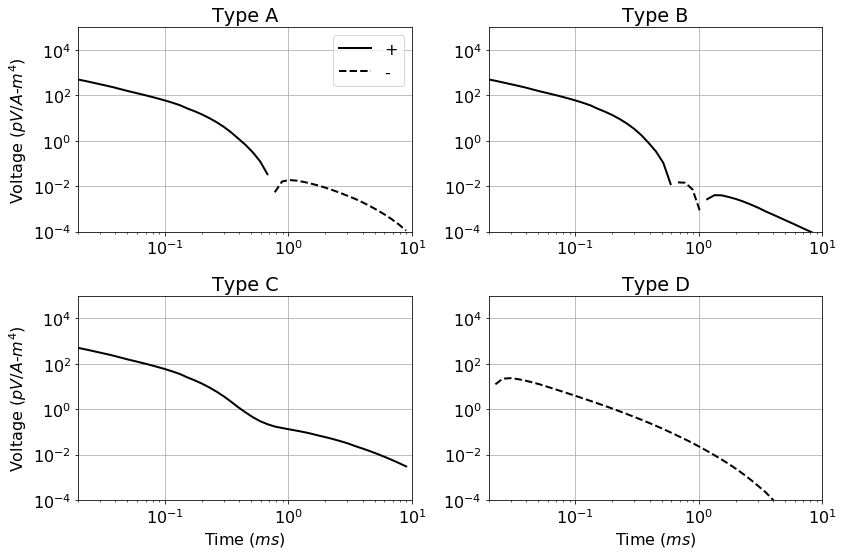

In [16]:
fig = plt.figure(figsize = (12, 8))
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)
legends = ['Fine-grained clays', 'Fine-grained sulphides']
ms = 1e3
data_p, data_n = get_dobs_pn(data_typeA.flatten()/moment)
ax1.loglog(rx_emip.times*ms, data_n, linestyle='-', color='k', lw=2)
ax1.loglog(rx_emip.times*ms, data_p, linestyle='--', color='k', lw=2)

data_p, data_n = get_dobs_pn(data_typeB.flatten()/moment)
ax2.loglog(rx_emip.times*ms, data_n, linestyle='-', color='k', lw=2)
ax2.loglog(rx_emip.times*ms, data_p, linestyle='--', color='k', lw=2)

data_p, data_n = get_dobs_pn(data_typeC.flatten()/moment)
ax3.loglog(rx_emip.times*ms, data_n, linestyle='-', color='k', lw=2)
ax3.loglog(rx_emip.times*ms, data_p, linestyle='--', color='k', lw=2)

data_p, data_n = get_dobs_pn(data_typeD.flatten()/moment)
ax4.loglog(rx_emip.times*ms, data_n, linestyle='-', color='k', lw=2)
ax4.loglog(rx_emip.times*ms, data_p, linestyle='--', color='k', lw=2)

titles = ['Type A', 'Type B', 'Type C', 'Type D']
for i, ax_temp in enumerate([ax1, ax2, ax3, ax4]):
    if i>1:
        ax_temp.set_xlabel("Time ($ms$)")     
    if i==0:
        ax_temp.legend(("+", "-"))
    ax_temp.set_xlim(2e-5*ms, 0.01*ms)
    ax_temp.grid()
    ax_temp.set_ylim(1e-4, 1e5)
    ax_temp.set_title(titles[i])
    if (i==0) or (i==2):
        ax_temp.set_ylabel("Voltage ($pV/A$-$m^4$)")    
ax.set_ylim(1e-4, 1e5)
plt.tight_layout()    
fig.savefig(figdir+"type_curves", dpi=300)